In [2]:
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import open3d as o3d
from ultralytics import YOLO
import shutil
from projection import yolo_txt

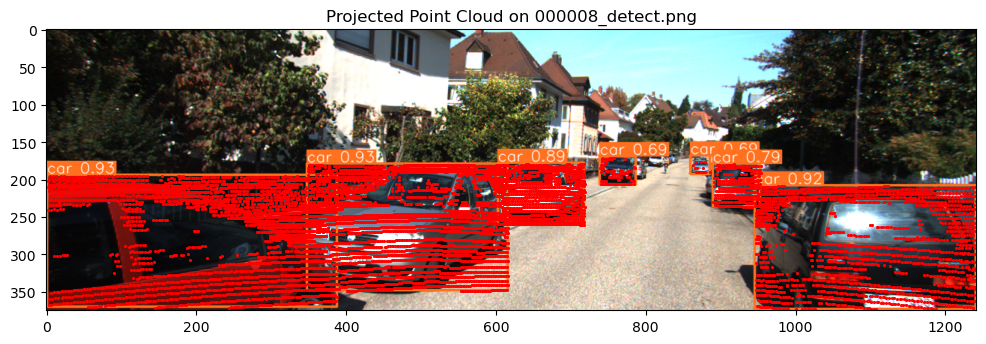

In [3]:
path = 'D:\lidar\point\\000008'
name = '000008'
# yolo_txt(name,path)
# 读取原始点云数据
# name = '000008'
binary = f'{path}/{name}.bin'
scan = np.fromfile(binary, dtype=np.float32).reshape((-1, 4))
original_pts = scan[:, :3]  # 提取 (x, y, z) 坐标
original_pts = np.array(original_pts)[original_pts[:, 0] > 0]
pcd_selected = o3d.geometry.PointCloud()
pcd_selected.points = o3d.utility.Vector3dVector(original_pts)

# 显示筛选后的点云
o3d.visualization.draw_geometries([pcd_selected])

# 读取相机参数
with open(f'{path}/{name}.txt','r') as f:
    calib = f.readlines()

# P2 (3 x 4) for left eye
P2 = np.array([float(x) for x in calib[2].strip('\n').split(' ')[1:]]).reshape(3, 4)
R0_rect = np.array([float(x) for x in calib[4].strip('\n').split(' ')[1:]]).reshape(3, 3)
R0_rect = np.insert(R0_rect, 3, values=[0, 0, 0], axis=0)
R0_rect = np.insert(R0_rect, 3, values=[0, 0, 0, 1], axis=1)
Tr_velo_to_cam = np.array([float(x) for x in calib[5].strip('\n').split(' ')[1:]]).reshape(3, 4)
Tr_velo_to_cam = np.insert(Tr_velo_to_cam, 3, values=[0, 0, 0, 1], axis=0)

# 读取图像尺寸
img_path = f'{path}/save/{name}.png'
img = mpimg.imread(img_path)
IMG_H, IMG_W, _ = img.shape

# 读取检测框信息
with open(f'{path}/save/labels/{name}.txt', 'r') as f:
    detections = [line.strip().split() for line in f.readlines()]

detections = [[float(x) for x in det] for det in detections]

# 投影点云到图像
velo = np.insert(original_pts, 3, 1, axis=1).T
cam = P2.dot(R0_rect.dot(Tr_velo_to_cam.dot(velo)))
cam = np.delete(cam, np.where(cam[2, :] < 0), axis=1)
cam[:2] /= cam[2, :]

# 获取落在检测框中的投影点云索引
projected_indices = []
for det in detections:
    _, u_center, v_center, width, height = det
    u_min = (u_center - width / 2) * IMG_W
    u_max = (u_center + width / 2) * IMG_W
    v_min = (v_center - height / 2) * IMG_H
    v_max = (v_center + height / 2) * IMG_H
    u, v = cam[:2]
    u_in = np.logical_and(u >= u_min, u <= u_max)
    v_in = np.logical_and(v >= v_min, v <= v_max)
    in_box = np.logical_and(u_in, v_in)
    projected_indices.append(np.where(in_box)[0])

# 合并所有投影点云索引
projected_indices = np.concatenate(projected_indices)

# 提取落在检测框中的投影点云数据
u, v, z = cam
projected_pts = np.stack([u[projected_indices], v[projected_indices]], axis=1)

# 显示投影点云和原始图像
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.scatter(projected_pts[:, 0], projected_pts[:, 1], c='r', s=1)
plt.title(f'Projected Point Cloud on {name}_detect.png')
plt.savefig(f'{path}/{name}_projection_detect_filter.png',bbox_inches='tight')
plt.show()


In [97]:
print(projected_pts.shape)
print(original_pts.shape)
pcd_orin = o3d.geometry.PointCloud()
pcd_orin.points = o3d.utility.Vector3dVector(original_pts)

box_pts = original_pts[projected_indices]
pcd_filter = o3d.geometry.PointCloud()
pcd_filter.points = o3d.utility.Vector3dVector(box_pts)

# 创建一个新的点云对象，其中仅包含不在pcd_filter中的点
pcd_orin_filtered = pcd_orin.select_by_index([i for i in range(len(original_pts)) if i not in projected_indices])

# 设置颜色
pcd_orin.paint_uniform_color([1, 0, 0])  # 原始点云为红色
pcd_filter.paint_uniform_color([0, 0, 1])  # 投影后的点云为蓝色
pcd_orin_filtered.paint_uniform_color([1, 0, 0])  # 过滤后的原始点云为红色

# 显示点云
o3d.visualization.draw_geometries([ pcd_orin_filtered,pcd_filter])

(8838, 2)
(60391, 3)


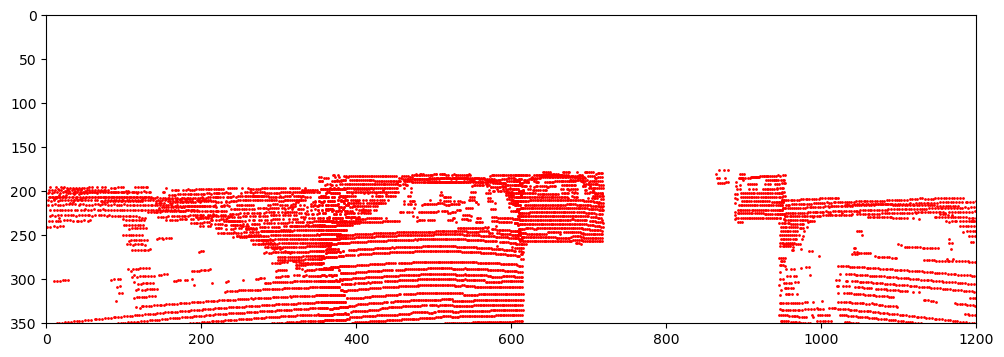

In [80]:
plt.figure(figsize=(12, 4))
plt.scatter(projected_pts[:, 0], projected_pts[:, 1], c='r', s=1)
plt.axis([0, 1200, 0, 350])
plt.gca().invert_yaxis()

In [74]:
print(projected_pts)

[[     388.36      196.02]
 [     384.58      196.02]
 [     376.95      195.98]
 ...
 [     871.59      190.06]
 [        869      190.07]
 [     866.44      190.09]]


In [98]:
box_pts = original_pts[projected_indices]
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(box_pts)
o3d.visualization.draw_geometries([pcd])
print(len(pcd.points))

8838


113 482 309 482


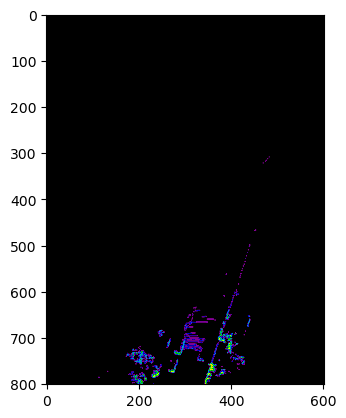

In [100]:
from PIL import Image
pointcloud = box_pts
side_range = (-30, 30)  # 左右距离
fwd_range = (0, 80)  # 后前距离
 
x_points = pointcloud[:, 0]
y_points = pointcloud[:, 1]
z_points = pointcloud[:, 2]
 
# 获得区域内的点
f_filt = np.logical_and(x_points > fwd_range[0], x_points < fwd_range[1])
s_filt = np.logical_and(y_points > side_range[0], y_points < side_range[1])
filter = np.logical_and(f_filt, s_filt)
indices = np.argwhere(filter).flatten()
x_points = x_points[indices]
y_points = y_points[indices]
z_points = z_points[indices]
 
res = 0.1  # 分辨率0.1m
x_img = (-y_points / res).astype(np.int32)
y_img = (-x_points / res).astype(np.int32)
# 调整坐标原点
x_img -= int(np.floor(side_range[0]) / res)
y_img += int(np.floor(fwd_range[1]) / res)
print(x_img.min(), x_img.max(), y_img.min(), x_img.max())
 
# 填充像素值
height_range = (-3, 1)
pixel_value = np.clip(a=z_points, a_max=height_range[1], a_min=height_range[0])
 
 
def scale_to_255(a, min, max, dtype=np.uint8):
	return ((a - min) / float(max - min) * 255).astype(dtype)
 
 
pixel_value = scale_to_255(pixel_value, height_range[0], height_range[1])
 
# 创建图像数组
x_max = 1 + int((side_range[1] - side_range[0]) / res)
y_max = 1 + int((fwd_range[1] - fwd_range[0]) / res)
im = np.zeros([y_max, x_max], dtype=np.uint8)
im[y_img, x_img] = pixel_value
 
# # imshow （灰度）
# im2 = Image.fromarray(im)
# im2.show()
 
# imshow （彩色）
plt.imshow(im, cmap="nipy_spectral", vmin=0, vmax=255)
plt.show()

In [69]:
bev_x, bev_y = np.meshgrid(np.arange(x_max), np.arange(y_max))
bev_x = bev_x.flatten()
bev_y = bev_y.flatten()
# 手动创建齐次坐标矩阵
bev_coords_homogeneous = np.vstack((bev_x, bev_y, np.ones_like(bev_x), np.ones_like(bev_x)))

# 使用投影矩阵P2将BEV图像的坐标投影到相机坐标系下的坐标
camera_coords = np.dot(P2, bev_coords_homogeneous)

# 去除齐次坐标
camera_coords /= camera_coords[2]

# 使用旋转矩阵R0_rect进行坐标变换，将相机坐标系下的坐标变换为世界坐标系下的坐标
world_coords = np.dot(R0_rect, camera_coords[:3])

# 在世界坐标系下，x 和 y 对调（因为相机坐标系和BEV图的坐标系可能不同）
world_coords[0], world_coords[1] = world_coords[1], world_coords[0]



# 绘制转换后的点云
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(world_coords[0], world_coords[1], world_coords[2], c='b', marker='o', s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('BEV图转换到相机坐标系下')
plt.show()


ValueError: shapes (4,4) and (3,481401) not aligned: 4 (dim 1) != 3 (dim 0)